In [10]:
from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from glob import glob
from PIL import Image
cudnn.benchmark = True

In [11]:
images_directory = 'images-1024x768'
masks_directory = 'masks-1024x768'
images_filenames = list(sorted(os.listdir(images_directory)))

random.seed(42)
random.shuffle(images_filenames)

In [12]:
class TinoDataset(Dataset):
    def __init__(self, images_filenames, images_directory, masks_directory, transform=None,mode = 'train' ):

        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform
        
        len_training =  int(len(images_filenames) * (70/100))
        len_val = int(len(images_filenames) * (90/100))

        
        if mode == "train":
            self.images_filenames = self.images_filenames[:len_training] 
        elif mode == "val":
            self.images_filenames = self.images_filenames[len_training:len_val]
        else :
            self.images_filenames = self.images_filenames[len_val:] 


        
    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
      
        
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(
            os.path.join(self.masks_directory, image_filename.replace(".jpg", ".png")), cv2.IMREAD_UNCHANGED,
        )


       
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        return image, mask

In [13]:
train_transform = A.Compose(
    [
        #A.Resize(256, 256),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
train_dataset = TinoDataset(images_filenames=images_filenames, images_directory=images_directory , masks_directory=masks_directory, transform=train_transform,)

val_transform = A.Compose(
    [#A.Resize(256, 256),
     A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()]
)
val_dataset = TinoDataset(images_filenames=images_filenames, images_directory=images_directory , masks_directory=masks_directory, transform=val_transform, mode = 'val')

In [17]:
def visualize_augmentations(dataset, idx=0, samples=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    
    figure, ax = plt.subplots(nrows=5, ncols=2, figsize=(10, 24))
   
    for i in range(samples):
        image, mask = dataset[idx]
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, cmap =  'gray',interpolation="nearest")
        ax[i, 0].set_title("Augmented image")
        ax[i, 1].set_title("Augmented mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

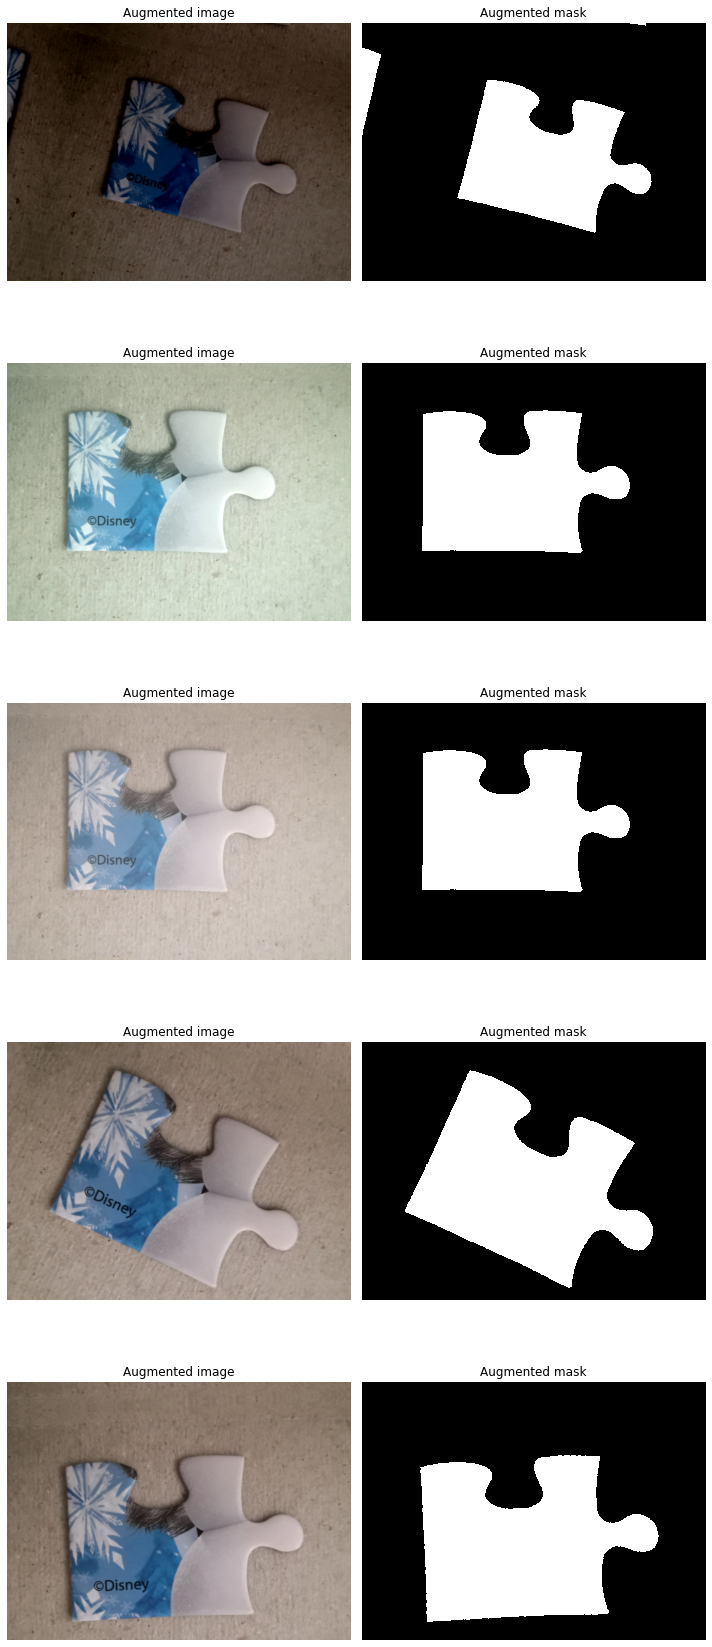

In [18]:
random.seed(42)
visualize_augmentations(train_dataset, idx=1)